# Game of Thrones Group Project - Analytics & Insight
An analysis of the entire Game of Thrones script (season 1 - 8)  

Rosanna Zhang  
Zhen Wang (Brandon)  
Tyler Mccluskey  
Trong Shen  
Jonathan Tang

In [81]:
import pandas as pd
import operator
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import string
import seaborn as sns; sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

from wordcloud import WordCloud


In [82]:
!pip install wordcloud

In [83]:
!pip install nltk
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/jonathan/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/jonathan/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /Users/jonathan/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /Users/jonathan/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /Users/jonathan/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /Users/jonathan/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-dat

True

### Import datsets
got: cleaned version of script removing duplicate names and spelling errors  
table: master table with additional attributes for 150 of the top characters in the show  
gotwords: cleaned version of script with House and tokenized sentences

In [84]:
#Import datasets into notebook
got = pd.read_csv('https://raw.githubusercontent.com/trong-shen/Game-of-Throne-Project/master/Game_of_Thrones_Script_clean.csv')
table = pd.read_csv('https://raw.githubusercontent.com/trong-shen/Game-of-Throne-Project/master/got_table.csv')
gotwords = pd.read_csv('https://raw.githubusercontent.com/trong-shen/Game-of-Throne-Project/master/GOT_house_csv.csv')
gotwords.columns = ['release_date', 'season', 'episode', 'eptitle', 'name', 'sentence', 'house', 'clean_sentence', 'num_words']

### Create new dataframes to analyze

In [85]:
#in table_df, create a new column called 'totalnumwords' to calculate the total number of words each
#character speaks for each name in table

table_df = table.copy() #create copy to preserve original variable
for i in table_df['name']:
    helper2 = gotwords.loc[gotwords['name']==i, ['num_words']]
    table_df.loc[table_df['name']==i, 'totalnumwords'] = helper2['num_words'].sum()


In [86]:
#define stopwords
stopword=nltk.corpus.stopwords.words('english')
stopword = stopword + ['l', 'k', 'would', 'us', 'one', 'know', 'like', 'want'] #add stopwords that we noticed were misspelled in the data 

#Define a function, remove_stopwords, which takes in a string and removes stop words
def remove_stopwords(sentence, stopwords = stopword):
    nostop = ''
    sentence = sentence.split()
    for i in range(len(sentence)):
        if sentence[i] not in stopwords: #for each word, if it is not a stopword
            nostop = nostop + ' ' + sentence[i] #then include it in the revised sentenced
    nostop = nostop.split()
    return nostop

In [87]:
#Implement the stop words function to a new column 
gotwords['Tokenized_No_Stop']=gotwords.clean_sentence.apply(lambda x:remove_stopwords(x))
gotwords.head()

,release_date,season,episode,eptitle,name,sentence,house,clean_sentence,num_words,Tokenized_No_Stop
0,4/17/2011,Season 1,Episode 1,Winter is Coming,waymar royce,What do you expect? They're savages. One lot s...,NaN,what do you expect they are savages one lot s...,27,"[expect, savages, lot, steals, goat, another, ..."
1,4/17/2011,Season 1,Episode 1,Winter is Coming,will,I've never seen wildlings do a thing like this...,NaN,i have never seen wildlings do a thing like t...,23,"[never, seen, wildlings, thing, never, seen, t..."
2,4/17/2011,Season 1,Episode 1,Winter is Coming,waymar royce,How close did you get?,NaN,how close did you get,5,"[close, get]"
3,4/17/2011,Season 1,Episode 1,Winter is Coming,will,Close as any man would.,NaN,close as any man would,5,"[close, man]"
4,4/17/2011,Season 1,Episode 1,Winter is Coming,gared,We should head back to the wall.,NaN,we should head back to the wall,7,"[head, back, wall]"


In [88]:
#left join gotwords and table_df to map the attributes to speaking characters in the gotwords script

bigtable = gotwords.merge(table_df, on='name', how='left') #left join ~ vlookup
bigtable

,release_date,season,episode,eptitle,name,sentence,house_x,clean_sentence,num_words,Tokenized_No_Stop,male,culture,house_y,spouse,isNoble,age,isAlive,salary,totalnumwords
0,4/17/2011,Season 1,Episode 1,Winter is Coming,waymar royce,What do you expect? They're savages. One lot s...,NaN,what do you expect they are savages one lot s...,27,"[expect, savages, lot, steals, goat, another, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4/17/2011,Season 1,Episode 1,Winter is Coming,will,I've never seen wildlings do a thing like this...,NaN,i have never seen wildlings do a thing like t...,23,"[never, seen, wildlings, thing, never, seen, t...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4/17/2011,Season 1,Episode 1,Winter is Coming,waymar royce,How close did you get?,NaN,how close did you get,5,"[close, get]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4/17/2011,Season 1,Episode 1,Winter is Coming,will,Close as any man would.,NaN,close as any man would,5,"[close, man]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4/17/2011,Season 1,Episode 1,Winter is Coming,gared,We should head back to the wall.,NaN,we should head back to the wall,7,"[head, back, wall]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23906,5/19/2019,Season 8,Episode 6,The Iron Throne,brienne,I think we can all agree that ships take prece...,House Tarth,i think we can all agree that ships take prec...,12,"[think, agree, ships, take, precedence, brothels]",0.0,Stormlands,House Tarth,0,0.0,0.0,1.0,100000.0,4077.0
23907,5/19/2019,Season 8,Episode 6,The Iron Throne,bronn,I think that's a very presumptuous statement.,House Bronn,i think that is a very presumptuous statement,8,"[think, presumptuous, statement]",1.0,Reach,House Bronn,Lollys Stokeworth,0.0,41.0,1.0,NaN,4586.0
23908,5/19/2019,Season 8,Episode 6,The Iron Throne,tyrion lannister,I once brought a jackass and a honeycomb into ...,House Lannister,i once brought a jackass and a honeycomb into...,11,"[brought, jackass, honeycomb, brothel]",1.0,Westerlands,House Lannister,Tysha,1.0,32.0,1.0,500000.0,26929.0
23909,5/19/2019,Season 8,Episode 6,The Iron Throne,man,The Queen in the North!,0,the queen in the north,5,"[queen, north]",1.0,0,0,0,0.0,0.0,0.0,NaN,2670.0


### Speaking lines in total and by gender
Speaking lines in the show remain roughly consistent in the first seven seasons, but then a dramatic dropoffis apparent in the last season. Passes the eye test as the last season seemed to have the most action and the least amount of lengthy dialogue scenes.The chart also reveals male characters had the majority of the speaking lines but according to my tableof the top 150 characters, there were a majority of male characters as well.

In [89]:
print(table.groupby(["male"]).count()) #show breakdown of female (code 0) and male (code 1)

      name  culture  house  spouse  isNoble  age  isAlive  salary
male                                                             
0       35       35     34      35       35   35       35       8
1      109      109    109     109      109  109      109      11


Text(0.5, 1.0, 'Words spoken by season')

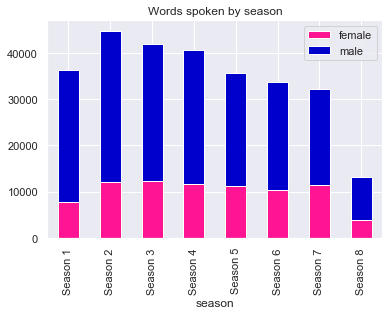

In [90]:
#pivot bigtable to show by season, how many words were spoken by male and female

ax = pd.pivot_table(bigtable, index=['season'], columns=['male'],values=['num_words'], aggfunc=np.sum).plot(kind='bar', stacked=True, color=['deeppink', 'mediumblue'])
ax.legend(['female', 'male'])
plt.title('Words spoken by season')

### Speaking lines by Culture
Culture in the tv show was the region/area each character originated from. For example House Stark and all its vassal houses that swore fealty to the reigning house would be considered Northmen, as they lived in the North. Predictably, the vast majority of the speaking lines belonged to the most ubiquitous houses in the show.

Text(0.5, 1.0, 'Words spoken by culture')

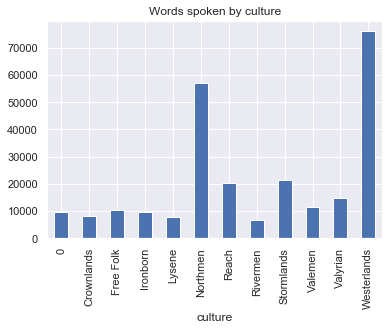

In [91]:
#pivot table by season, how much each Culture spoke

#needed to filter pivot table to remove any empty values in culture, which there are many
ax = pd.pivot_table(bigtable[bigtable.culture != np.nan], index=['culture'],values=['num_words'], aggfunc=np.sum)
ax[ax['num_words']>5000].plot(kind='bar').get_legend().remove()
plt.title('Words spoken by culture')

### Speaking lines by House
Very similar to Culture, a House is normally a noble family that presides over its lands, people, and territories. In Westeros, the fictional continent is divided into seven Great Houses, known as the Seven Kingdoms. Most recently, all seven houses swore fealty to House Baratheon who reigned on the Iron Throne. Similarly to culture, the vast majority of lines are spoken by the main characters in House Lannister, Stark, and Targaryen.

Text(0.5, 1.0, 'Words spoken by house')

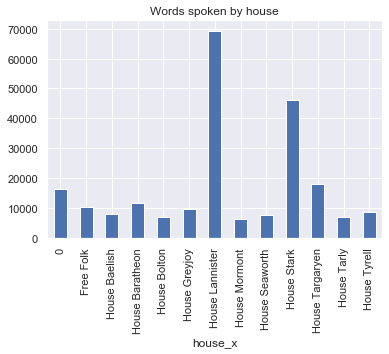

In [92]:
#pivot table by season, how much each House spoke

#needed to filter pivot table to remove any empty values in house, which there are many
test = pd.pivot_table(bigtable[bigtable.house_x != np.nan], index=['house_x'],values=['num_words'], aggfunc=np.sum)
test[test['num_words']>5000].plot(kind='bar').get_legend().remove()
plt.title('Words spoken by house')

### Speaking lines for the top 3 houses by season

From the chart below, House Stark had most of the speaking lines in the show but slowly as the show went on, surrendered more and more to House Lannister and House Targaryen. It also shows that although the total speaking lines across all houses decrease as seasons went on, House Targaryen maintains a consistent speaking level. This is probably due to both House Stark and House Lannister losing key members of their family due to being killed off while House Targaryren really only has one speaking character, Daenerys.

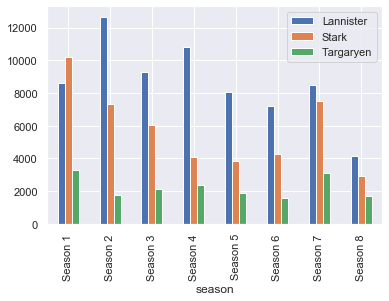

In [93]:
#pivot table for Lannister, Stark, Targaryen houses by season

test = pd.pivot_table(bigtable[bigtable.house_x != np.nan], index=['season'],columns=['house_y'],values=['num_words'], aggfunc=np.sum)
ax =test.iloc[:, (test.columns.get_level_values(1)=='House Stark') | (test.columns.get_level_values(1)=='House Lannister') | (test.columns.get_level_values(1)=='House Targaryen')].plot(kind='bar')
ax.legend(['Lannister', 'Stark', 'Targaryen'])

### Speaking lines by characters who are alive by the end of the show
The Game of Thrones show is infamously known for killing us many of its characters and it's no surprise from the chart that the majority of speaking lines are from characters who are eventually killed off.

Text(0.5, 1.0, 'Words spoken by living characters by end of show')

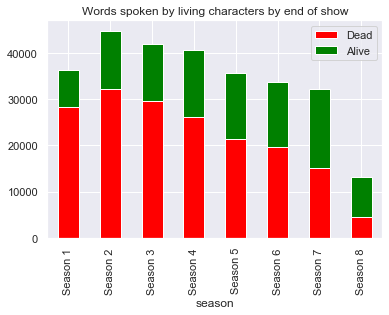

In [94]:
#pivot table by season of dead and alive characters
ax = pd.pivot_table(bigtable[bigtable.isAlive != np.nan], index=['season'], columns=['isAlive'],values=['num_words'], aggfunc=np.sum).plot(kind='bar', stacked=True, color=['red', 'green'])
ax.legend(['Dead', 'Alive'])
plt.title('Words spoken by living characters by end of show')

### Working with salary data and related insights
The next section is mainly related to seeing if there is any insight that can be drawn upon salary data for each character and how it relates to how many speaking lines they have. Salary data was researched from multiple entertainment articles online and was lump sum (USD) salary per episode. Note that the salary data is slightly inaccurate as many if not all characters got progressively more and more money as the show went on. I used the salary per episode based on the latest/final earning figures of actors/actresses.

In [95]:
#test for any null values
test = gotwords['name']
print(np.where(pd.isnull(test)))
test = table['salary']
print(np.where(pd.isnull(test)))

(array([], dtype=int64),)
(array([  0,   1,   2,   3,   4,   6,   7,   8,   9,  12,  13,  14,  16,
        17,  18,  20,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  41,  42,  43,  44,  45,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  70,  71,  72,  73,  74,
        75,  76,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 133, 135,
       136, 137, 138, 139, 140, 141, 142, 143]),)


I created a new pivot table called <i> mainchar </i> which creates a table with all characters with available salary data. New columns are then created such as number of episodes each character appears in and total salary. 'sPer' is the column where I compare an actor's total salary with the number of words.

In [96]:
#create new pivot table with characters that have salary data
mainchar = table.loc[table['salary'].notnull(), ['name', 'male', 'culture', 'house', 'isNoble', 'age', 'isAlive', 'salary']]
mainchar = mainchar.reset_index() #reset index
del mainchar['index']

for i in mainchar['name']:
    helper = gotwords.loc[gotwords['name']==i, ['eptitle']]
    mainchar.loc[mainchar['name']==i, 'numep']=len(helper['eptitle'].unique())
    mainchar['tsalary'] = mainchar['salary'] * mainchar['numep']
    
    helper2 = gotwords.loc[gotwords['name']==i, ['num_words']]
    mainchar.loc[mainchar['name']==i, 'numword'] = helper2['num_words'].sum()
    
    mainchar['sPer'] = mainchar['tsalary'] / mainchar['numword']

mainchar

,name,male,culture,house,isNoble,age,isAlive,salary,numep,tsalary,numword,sPer
0,arya stark,0,Northmen,House Stark,1,16,1,175000.0,57.0,9975000.0,6795.0,1467.991170
1,bran stark,1,Northmen,House Stark,1,15,1,175000.0,38.0,6650000.0,3458.0,1923.076923
2,brienne,0,Stormlands,House Tarth,0,0,1,100000.0,33.0,3300000.0,4077.0,809.418690
3,cersei lannister,0,Westerlands,House Lannister,1,39,0,500000.0,58.0,29000000.0,14940.0,1941.097724
4,daenerys targaryen,0,Valyrian,House Targaryen,1,21,0,500000.0,60.0,30000000.0,12715.0,2359.418010
5,davos,1,Stormlands,House Seaworth,0,45,1,300000.0,40.0,12000000.0,7142.0,1680.201624
6,jaime lannister,1,Westerlands,House Lannister,1,39,0,500000.0,54.0,27000000.0,12316.0,2192.270218
7,jon snow,1,Northmen,House Stark,1,22,1,500000.0,60.0,30000000.0,12915.0,2322.880372
8,jorah mormont,1,Northmen,House Mormont,1,51,0,100000.0,49.0,4900000.0,4792.0,1022.537563
9,margaery tyrell,0,Reach,House Tyrell,1,22,0,100000.0,24.0,2400000.0,3268.0,734.394125


### Total salary vs. Number of words spoken
As expected, those who spoke the most, generally made the most and there is a clear trend with the 19 characters salary data is available from. The upper right point is Tyrion Lannister (actor Peter Dinklage), who is the most speaking lines, appears in most episodes, and has made the most earnings.

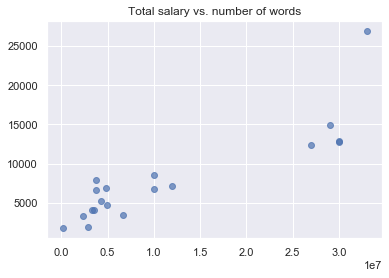

In [97]:
plt.scatter(mainchar['tsalary'], mainchar['numword'], alpha=0.7)
plt.title('Total salary vs. number of words')
plt.show()


### Fitting a line over salary data
Let's attempt to draw a line to fit the data using linear regression. Using scikit's Linear Regression module. We see that the R2 score is 76%.

In [98]:
x_knot = mainchar['tsalary']
y_knot = mainchar['numword']
x = x_knot[:, np.newaxis] #need to transfrom the x,y values for the model to take it
y = y_knot[:, np.newaxis] 

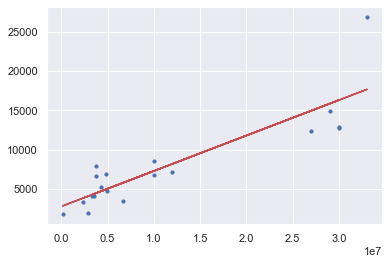

0.7615320870900408


In [99]:
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

plt.scatter(x, y, s=10)
plt.plot(x, y_pred, color='r') #plot the predicted y values on top of scatter plot
plt.show()
print(r2_score(y, y_pred)) #R2 score

Let's now try polynomial regression, which is simply a special case of linear regression. We add a feature of degree 3 to the linear regression. R2 improves slightly to 0.809. I would say this is a good balance between underfitting the data and overfitting the residual errors.

2539.87488067367
0.80938777139962


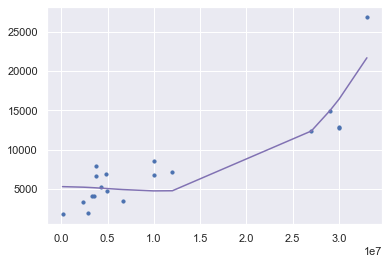

In [100]:

polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x)

model2 = LinearRegression()
model2.fit(x_poly, y)
y_poly_pred = model2.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()

### Dollars per word for each main character
From this chart, we can see that Daenerys gets paid the most for each word she spoke on the show, around 2500 per word. The top 4 are not a surprise, but the fifth on the list, Bran Stark, comes a surprise because he isn't considered a top character on the show. Even though he did not get paid much per episode, because he spoke so little, he made much more than his counterparts per word he spoke. The most verbose character, Tyrion, is right in the middle making an average 1200 per word spoken.

Text(0.5, 1.0, 'Dollars per word for each main character')

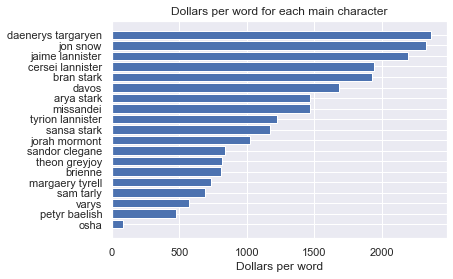

In [101]:
mainchar_s = mainchar.sort_values('sPer')
plt.barh(mainchar_s['name'], mainchar_s['sPer'])
plt.xlabel('Dollars per word')
plt.title('Dollars per word for each main character')

### Create cumulative tables
Created multiple tables that shows data regarding episodes vs. main character. To analyze what each character did per episode, I made new dataframes to show whether each character appeared in each episode, how much each actor made per episode (using a simple mapping exercise), and a cumulative running total of how much each actor made as the show progressed per episode.

In [102]:
#Get the unique episode titles and then use that as the index for a new pivot table with columns main characters
eplist = gotwords['eptitle'].unique()
newdf =pd.DataFrame(eplist, columns=['epname'])
new_cols = mainchar['name'].unique()
new_cols = np.array(new_cols).tolist()
new_cols.insert(0, 'epname')
newdf = newdf.reindex(columns=new_cols, fill_value=0) #make the characters the columns
newdf = newdf.set_index('epname')
spokedf = newdf.copy() #copy df



In [103]:
#iterate over each character and each episode, and check if that character appeared in that episode
for i in mainchar['name']:
    for j in eplist:
        isIn = len(gotwords.loc[(gotwords['eptitle']==j) & (gotwords['name']==i), 'clean_sentence'].values)
        if isIn>0:
            spokedf.loc[j, i]= 1
            
cumdf = spokedf.copy()
cumdf = cumdf.cumsum() #the df that shows the cumulative number of episodes each character appeared in

In [104]:
#the df that maps the salary of each character to the cumulative appearance df
cumSal_df = cumdf.mul(list(mainchar['salary']), axis =1)
cumSal_df

,arya stark,bran stark,brienne,cersei lannister,daenerys targaryen,davos,jaime lannister,jon snow,jorah mormont,margaery tyrell,missandei,osha,petyr baelish,sam tarly,sandor clegane,sansa stark,theon greyjoy,tyrion lannister,varys
epname,,,,,,,,,,,,,,,,,,,
Winter is Coming,175000.0,175000.0,0.0,500000.0,500000.0,0.0,500000.0,500000.0,100000.0,0.0,0.0,0.0,0.0,0.0,100000.0,175000.0,100000.0,500000.0,0.0
The Kingsroad,350000.0,175000.0,0.0,1000000.0,1000000.0,0.0,1000000.0,1000000.0,200000.0,0.0,0.0,0.0,0.0,0.0,200000.0,350000.0,200000.0,1000000.0,0.0
Lord Snow,525000.0,350000.0,0.0,1500000.0,1500000.0,0.0,1500000.0,1500000.0,300000.0,0.0,0.0,0.0,100000.0,0.0,200000.0,525000.0,200000.0,1500000.0,100000.0
"Cripples, Bastards and Broken Things",700000.0,525000.0,0.0,2000000.0,2000000.0,0.0,2000000.0,2000000.0,400000.0,0.0,0.0,0.0,200000.0,100000.0,200000.0,700000.0,300000.0,2000000.0,200000.0
The Wolf and the Lion,875000.0,700000.0,0.0,2500000.0,2000000.0,0.0,2500000.0,2000000.0,400000.0,0.0,0.0,0.0,300000.0,100000.0,300000.0,875000.0,400000.0,2500000.0,300000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A Knight of the Seven Kingdoms,9450000.0,6125000.0,3100000.0,28500000.0,28000000.0,10800000.0,25500000.0,28000000.0,4800000.0,2400000.0,2800000.0,140000.0,3800000.0,4500000.0,3200000.0,9625000.0,4200000.0,31000000.0,3600000.0
The Long Night,9625000.0,6300000.0,3200000.0,28500000.0,28500000.0,11100000.0,26000000.0,28500000.0,4900000.0,2400000.0,2900000.0,140000.0,3800000.0,4600000.0,3300000.0,9800000.0,4300000.0,31500000.0,3700000.0
The Last of the Starks,9625000.0,6475000.0,3200000.0,28500000.0,29000000.0,11400000.0,26500000.0,29000000.0,4900000.0,2400000.0,2900000.0,140000.0,3800000.0,4700000.0,3400000.0,9800000.0,4300000.0,32000000.0,3700000.0


### Plot the cumulative salary of each main character
Not a lot of insight can be derived from this chart, although it does show how the top 5 characters of the show (Cersei, Daenerys, Jon, Jaime, and Tyrion) far outpace the rest of the cast in terms of cumulative earnings.

Text(0.5, 1.0, 'Cumulative salary by episode over time')

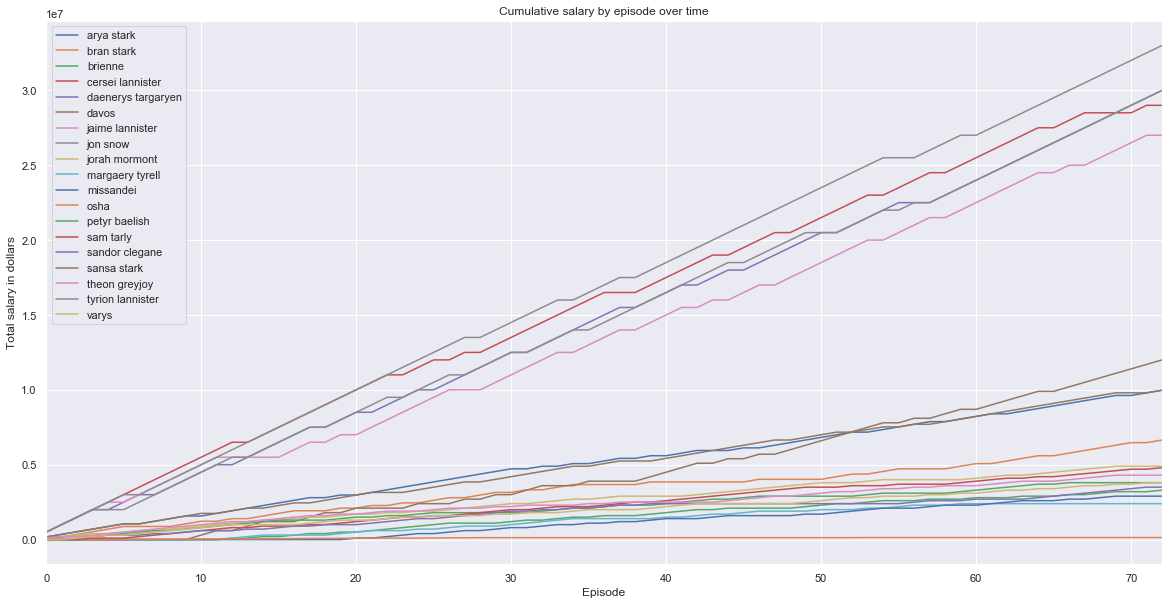

In [105]:
cumSal_df = cumSal_df.reset_index(drop=True)
cumSal_df.plot(figsize=(20,10))
plt.xlabel('Episode')
plt.ylabel('Total salary in dollars')
plt.title('Cumulative salary by episode over time')
#plt.savefig('GoTsalaryTS.png')

### Heatmap of words spoken
Created a heatmap of all total words spoken per episode for each character. Needed to make a new df that counts how many words each character spoke each episode. No surprises here as the main characters dominate the heatmap in most episodes. This does show which episodes the minor characters shine in - for example Sam Tarly mainly spoke in the episode 'The Watchers on the Wall.'

In [106]:
wordsdf = newdf.copy()

#iterate on each name and episode and determine how many words were spoken per episode per character
for i in mainchar['name']:
    for j in eplist:
        wordslist = gotwords.loc[(gotwords['eptitle']==j) & (gotwords['name']==i), 'num_words'].values
        wordsdf.loc[j, i]= np.sum(wordslist)


Text(0.5, 1, 'Heatmap of words spoken in all episodes')

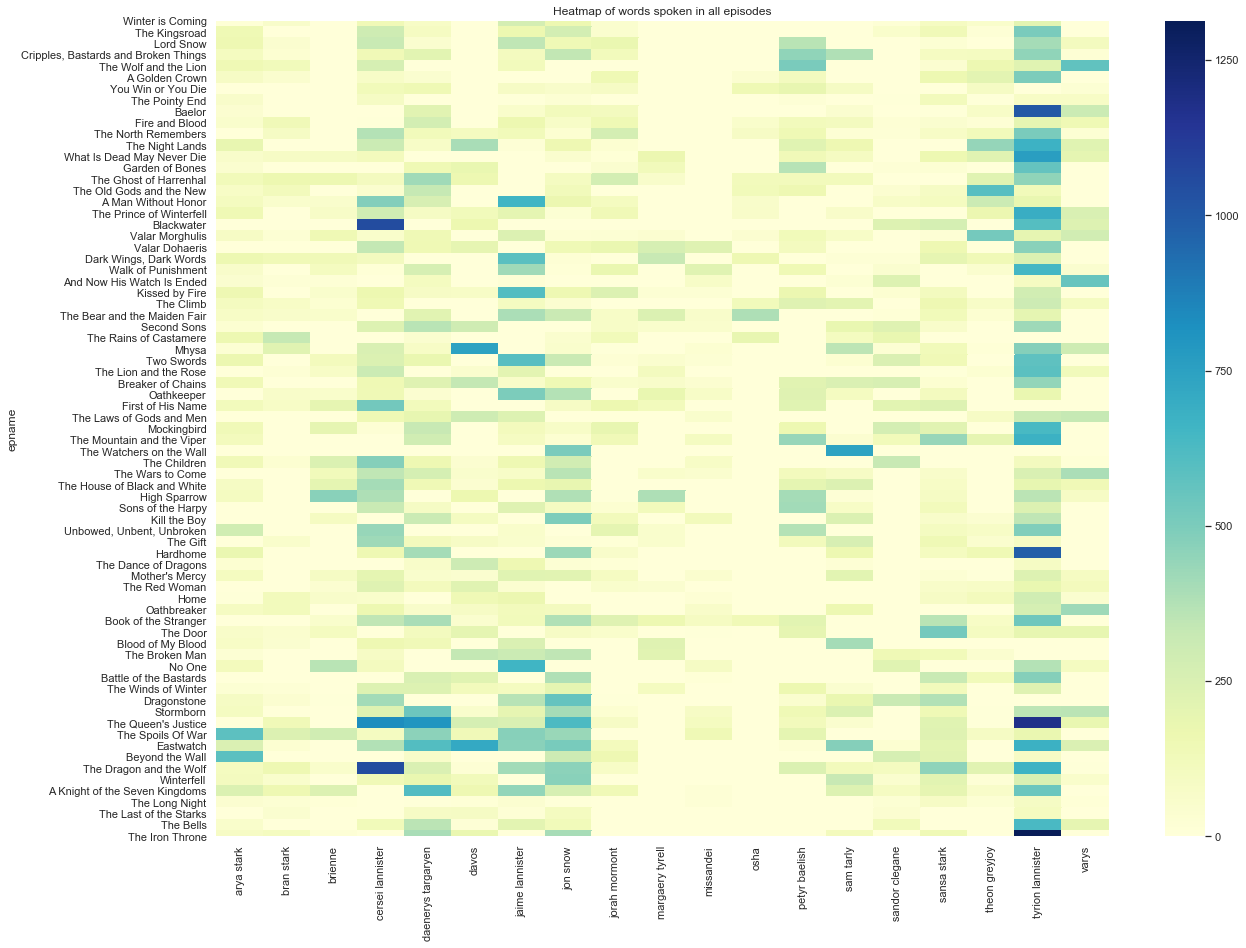

In [107]:
plt.subplots(figsize=(20,15))
ax = sns.heatmap(wordsdf, cmap="YlGnBu")
plt.title('Heatmap of words spoken in all episodes')
#plt.savefig('GoTheatmap.png')

### Heatmap of dollars per word spoken per character
Building on the previous heatmap, this depicts which characters made the most 'bang for their buck' per episode. The darker spots represents episodes where the episode spoke very little and made the most amount of money per word spoken in that episode. The heatmap is based on a log scale because the scale was too high for a linear scale. The darkest spot belongs to Jaime Lannister, who on the season 3 finale named 'Mhysa', said exactly only one word the entire episode to collect his 500,000 dollar paycheck for appearing in the episode. That word was Cersei.

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


Text(0.5, 1, 'Heatmap of dollars per word spoken per episode')

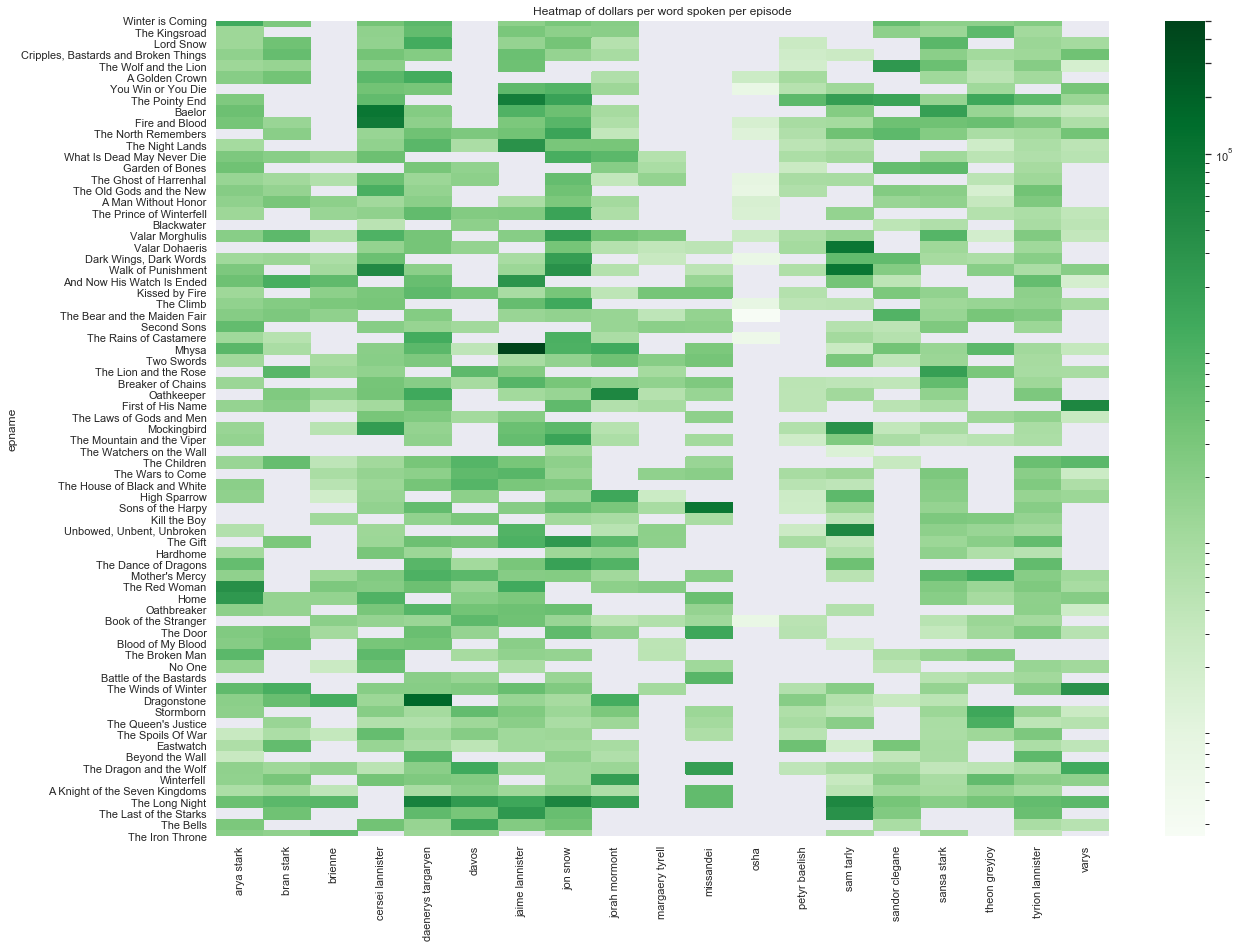

In [108]:
sal_df = spokedf.mul(list(mainchar['salary']), axis =1)
salwords_df = sal_df / wordsdf

plt.subplots(figsize=(20,15))
ax = sns.heatmap(salwords_df, norm=LogNorm(), cmap="Greens")
plt.title('Heatmap of dollars per word spoken per episode')
#plt.savefig('GoTdollarsperword.png')

### Word Cloud of Words by Character and Houses

Going back to gotwords, we can now assess trends related to top words spoken by top characters and top houses, defined by the most words spoken.

In [109]:
gotwords.head()

,release_date,season,episode,eptitle,name,sentence,house,clean_sentence,num_words,Tokenized_No_Stop
0,4/17/2011,Season 1,Episode 1,Winter is Coming,waymar royce,What do you expect? They're savages. One lot s...,NaN,what do you expect they are savages one lot s...,27,"[expect, savages, lot, steals, goat, another, ..."
1,4/17/2011,Season 1,Episode 1,Winter is Coming,will,I've never seen wildlings do a thing like this...,NaN,i have never seen wildlings do a thing like t...,23,"[never, seen, wildlings, thing, never, seen, t..."
2,4/17/2011,Season 1,Episode 1,Winter is Coming,waymar royce,How close did you get?,NaN,how close did you get,5,"[close, get]"
3,4/17/2011,Season 1,Episode 1,Winter is Coming,will,Close as any man would.,NaN,close as any man would,5,"[close, man]"
4,4/17/2011,Season 1,Episode 1,Winter is Coming,gared,We should head back to the wall.,NaN,we should head back to the wall,7,"[head, back, wall]"


In [110]:
#to find the characters with most words and define the top 10 characters in the show

GOTData = pd.pivot_table(gotwords, values='num_words', index='name', aggfunc=np.sum) #pivot number of words by character name

GOT_Top10 = GOTData.sort_values('num_words') #find characters with the most words said
GOT_Top10 = GOT_Top10.tail(10)

GOT_Top10 = pd.DataFrame(GOT_Top10.to_records()) #convert into a dataframe
GOT_Top10

,name,num_words
0,arya stark,6795
1,sam tarly,6922
2,davos,7142
3,petyr baelish,7953
4,sansa stark,8514
5,jaime lannister,12316
6,daenerys targaryen,12715
7,jon snow,12915
8,cersei lannister,14940
9,tyrion lannister,26929


In [111]:
#to find each characters favourite word (i.e. most repeated word, not including stopwords)

#define a function, character_words, that appends all tokenized_no_stop words for a chosen character in the form of a list
def character_words(character):
    l = []
    for i in range(len(gotwords['name'])):
        if character in gotwords['name'][i]:
            l = l + gotwords['Tokenized_No_Stop'][i]
    return l

#define a function, most_freq, that takes a character and outputs the listing of words spoken & number of times they were spoken
def most_freq(s):
    wordlist = character_words(s) #get the list of words said for the character
    word_dict = {} #create dictionary to track count of unique words
    for i in wordlist:
        if i in word_dict.keys():
            word_dict[i] = word_dict[i] + 1
        else:
            word_dict[i] = 1
    freq = sorted(word_dict.items(), key=lambda x: x[1], reverse=True) #sort by value
    return freq

In [112]:
GOT_Top10['Fave_Word'] = GOT_Top10.name.apply(lambda x: most_freq(x)[0][0]) #obtain favourite word for top 5 characters
GOT_Top10['Fave_Word_Freq'] = GOT_Top10.name.apply(lambda x: most_freq(x)[0][1]) #obtain frequency of favourite word
GOT_Top10

,name,num_words,Fave_Word,Fave_Word_Freq
0,arya stark,6795,go,31
1,sam tarly,6922,oh,34
2,davos,7142,grace,44
3,petyr baelish,7953,lord,36
4,sansa stark,8514,lord,54
5,jaime lannister,12316,get,36
6,daenerys targaryen,12715,take,47
7,jon snow,12915,men,49
8,cersei lannister,14940,father,53
9,tyrion lannister,26929,father,83


In [113]:
#From GOT_Top10 above, it can be seen that the top 5 characters by word count are Tyrion, Cersei, Jon, Daenerys, and Jaime

Tyrion = ' '.join(character_words('tyrion'))
Cersei = ' '.join(character_words('cersei'))
Jon = ' '.join(character_words('jon snow'))
Daenerys = ' '.join(character_words('daenerys'))
Jaime = ' '.join(character_words('jaime'))

In [114]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


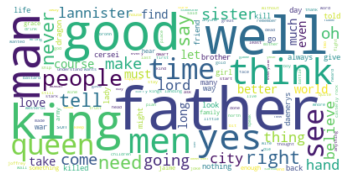

In [115]:
#Generate word cloud for Tyrion using the top 150 words

wordcloud = WordCloud(max_font_size=70, max_words=150, background_color="white").generate(Tyrion)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

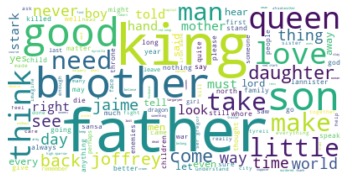

In [116]:
wordcloud = WordCloud(max_font_size=70, max_words=150, background_color="white").generate(Cersei)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

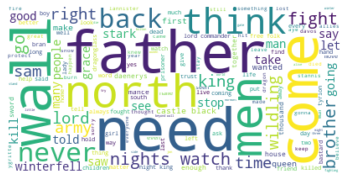

In [117]:
wordcloud = WordCloud(max_font_size=70, max_words=150, background_color="white").generate(Jon)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

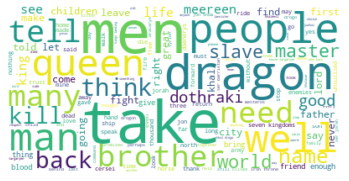

In [118]:
wordcloud = WordCloud(max_font_size=70, max_words=150, background_color="white").generate(Daenerys)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

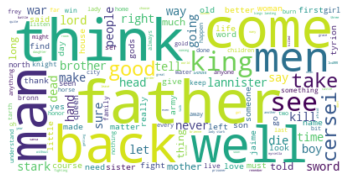

In [119]:
wordcloud = WordCloud(max_font_size=70, max_words=150, background_color="white").generate(Jaime)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The word clouds above show the top words spoken for each of the top 5 characters. It is interesting to note that the word "father" is consistent for Jaime Lannister, Cersei Lannister, Jon Snow, and Tyrion Lannister, but not Daenerys Targaryen, which is consistent with the storyline, as Daenerys did not have a strong father figure throughout her childhood.

Create wordclouds for top 3 houses in the series, defined by the houses with the most words spoken.

In [120]:
gotwords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23911 entries, 0 to 23910
Data columns (total 10 columns):
release_date         23911 non-null object
season               23911 non-null object
episode              23911 non-null object
eptitle              23911 non-null object
name                 23911 non-null object
sentence             23911 non-null object
house                21639 non-null object
clean_sentence       23911 non-null object
num_words            23911 non-null int64
Tokenized_No_Stop    23911 non-null object
dtypes: int64(1), object(9)
memory usage: 1.8+ MB


In [121]:
#From the above, we can see that there are characters that do not belong in a house/ are not significant enough to have a house. As such, we can remove these lines.

GOTHouse = gotwords.dropna()
GOTHouse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21639 entries, 15 to 23909
Data columns (total 10 columns):
release_date         21639 non-null object
season               21639 non-null object
episode              21639 non-null object
eptitle              21639 non-null object
name                 21639 non-null object
sentence             21639 non-null object
house                21639 non-null object
clean_sentence       21639 non-null object
num_words            21639 non-null int64
Tokenized_No_Stop    21639 non-null object
dtypes: int64(1), object(9)
memory usage: 1.8+ MB


In [122]:
#from the data above, it looks like there are still houses defined as "0"
#filter these out to examine them further
GOT0 = GOTHouse[GOTHouse.house == '0']
GOT0

,release_date,season,episode,eptitle,name,sentence,house,clean_sentence,num_words,Tokenized_No_Stop
626,5/1/2011,Season 1,Episode 3,Lord Snow,varys,Lord Stark.,0,lord stark,2,"[lord, stark]"
628,5/1/2011,Season 1,Episode 3,Lord Snow,varys,I was grievously sorry to hear of your trouble...,0,i was grievously sorry to hear of your troubl...,21,"[grievously, sorry, hear, troubles, kingsroad,..."
643,5/1/2011,Season 1,Episode 3,Lord Snow,varys,His Grace has many cares. He entrusts some sma...,0,his grace has many cares he entrusts some sma...,18,"[grace, many, cares, entrusts, small, matters,..."
660,5/1/2011,Season 1,Episode 3,Lord Snow,varys,"You are the King's Hand, Lord Stark, we serve ...",0,you are the kings hand lord stark we serve at...,12,"[kings, hand, lord, stark, serve, pleasure]"
755,5/1/2011,Season 1,Episode 3,Lord Snow,varys,Lady Stark.,0,lady stark,2,"[lady, stark]"
...,...,...,...,...,...,...,...,...,...,...
23599,5/12/2019,Season 8,Episode 5,The Bells,man,My God!,0,my god,2,[god]
23637,5/12/2019,Season 8,Episode 5,The Bells,man,Out of the way!,0,out of the way,4,[way]
23638,5/12/2019,Season 8,Episode 5,The Bells,man,No!,0,no,1,[]
23653,5/12/2019,Season 8,Episode 5,The Bells,man,"Come on, quickly. All of you.",0,come on quickly all of you,6,"[come, quickly]"


In [123]:
#Based on the results above, the characters with house "0" have no house (i.e. they have no house allegiance, or their character is not significant enough to be assigned a house)
#Therefore, we should further drop these lines from our dataframe
GOTHouse = GOTHouse[GOTHouse.house != '0']


In [124]:
GOTHouse = pd.DataFrame(GOTHouse.to_records()) #Ensure GOTHouse is a dataframe


In [125]:
GOTHouseData = pd.pivot_table(GOTHouse, values = 'num_words', index = 'house', aggfunc=np.sum)
GOTHouseData = GOTHouseData.sort_values('num_words') #find Houses with the most words said
GOT_TopHouses = GOTHouseData.tail(10)

GOT_TopHouses = pd.DataFrame(GOT_TopHouses.to_records()) #convert into a dataframe
GOT_TopHouses

,house,num_words
0,House Tarly,7064
1,House Seaworth,7567
2,House Baelish,7953
3,House Tyrell,8437
4,House Greyjoy,9716
5,Free Folk,10182
6,House Baratheon,11692
7,House Targaryen,17859
8,House Stark,46192
9,House Lannister,69363


In [126]:
#define a function, house_words, that appends all tokenized_no_stop words for a chosen character in the form of a list
def house_words(house):
    l = []
    for i in range(len(GOTHouse['house'])):
        if house in GOTHouse['house'][i]:
            l = l + GOTHouse['Tokenized_No_Stop'][i]
    return l

#define a function, house_most_freq, that takes a character and outputs the listing of words spoken & number of times they were spoken
def house_most_freq(s):
    wordlist = house_words(s) #get the list of words said for the character
    word_dict = {} #create dictionary to track count of unique words
    for i in wordlist:
        if i in word_dict.keys():
            word_dict[i] = word_dict[i] + 1
        else:
            word_dict[i] = 1
    freq = sorted(word_dict.items(), key=lambda x: x[1], reverse=True) #sort by value
    return freq

In [127]:
#use house_most_freq function defined above on "House" to find favourite word of top 3 houses
GOT_TopHouses['Fave_Word'] = GOT_TopHouses.house.apply(lambda x: house_most_freq(x)[0][0]) #obtain favourite word for top 5 characters
GOT_TopHouses['Fave_Word_Freq'] = GOT_TopHouses.house.apply(lambda x: house_most_freq(x)[0][1]) #obtain frequency of favourite word
GOT_TopHouses

,house,num_words,Fave_Word,Fave_Word_Freq
0,House Tarly,7064,well,34
1,House Seaworth,7567,grace,45
2,House Baelish,7953,lord,36
3,House Tyrell,8437,king,31
4,House Greyjoy,9716,iron,48
5,Free Folk,10182,jon,39
6,House Baratheon,11692,king,46
7,House Targaryen,17859,men,70
8,House Stark,46192,lord,205
9,House Lannister,69363,king,224


In [128]:
#From the GOT_TopHouses analysis above, the top three houses by word count are House Lannister, House Stark, and House Targaryen

Lannister = ' '.join(house_words('Lannister'))
Stark = ' '.join(house_words('Stark'))
Targaryen = ' '.join(house_words('Targaryen'))

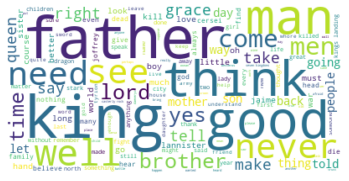

In [129]:
#Create wordcloud for top 3 houses: Lannister
wordcloud = WordCloud(max_font_size=70, max_words=150, background_color="white").generate(Lannister)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

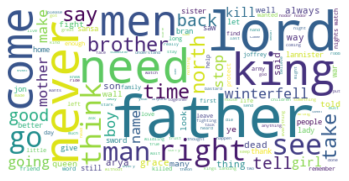

In [130]:
#Create wordcloud for top 3 houses: Stark
wordcloud = WordCloud(max_font_size=70, max_words=150, background_color="white").generate(Stark)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

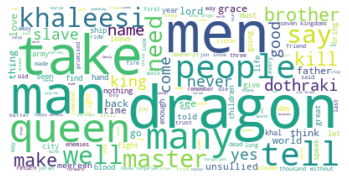

In [131]:
#Create wordcloud for top 3 houses: Targaryen
wordcloud = WordCloud(max_font_size=70, max_words=150, background_color="white").generate(Targaryen)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()